In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
import os
from datetime import datetime

import dask.dataframe as dd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas as pd
from matplotlib import collections, colors
from matplotlib.colors import to_rgba
from mpl_toolkits.basemap import Basemap
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

from real_analysis import (
    algo_data_file,
    calculate_azimean,
    calculate_distance_around_tc,
    calculate_theta_around_tc,
    create_tc_plots,
    crop,
    get_coordinates,
    get_plot_filename,
    get_qgrid,
    interpolate_data,
    outdir,
    plot_azimean,
)
from utils import load_complete_datasets, load_simulation_data

In [6]:
from plotting import plot_max_intensity_coloring

In [10]:
def calc_distance(row, tc):
    r_e = 6371229  # radius of Earth

    if row.lon == tc.lon and row.lat == tc.lat:
        return 0

    lon1, lat1, lon2, lat2 = np.deg2rad([row.lon, row.lat, tc.lon, tc.lat])
    dist = r_e * np.arccos(
        np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2)
    )
    return dist

def close_tracks(group, ref_tc):
    tmp_group = group[group.date == ref_tc.date]
    if len(tmp_group.index) == 0:
        return False
    tmp_tc = tmp_group.iloc[0]
    if calc_distance(tmp_tc, ref_tc) < 70000:
        return True
    else:
        return False

In [56]:
bmap_params = dict(
    llcrnrlon=-113.0,
    llcrnrlat=-20.0,
    urcrnrlon=40.0,
    urcrnrlat=60.0,
    projection="lcc",
    lat_1=20.0,
    lat_2=40.0,
    lon_0=-60.0,
    resolution="l",
    area_thresh=1000.0,
)


def plot_occurrence(
    df,
    tc_id,
    filename=None,
    min_lifetime=3,
    bmap_params=bmap_params,
    title=None,
):
    data = df.groupby("tc_id").filter(lambda x: len(x) >= min_lifetime)
    
    fig = plt.figure(figsize=(12, 8), dpi=300)
    ax1 = fig.add_subplot(1, 1, 1)

    grouped = data.groupby("tc_id")
    base_tc_ls = grouped.get_group(tc_id)
    maxrow_idx = base_tc_ls["maxwind"].idxmax()
    base_tc = base_tc_ls.loc[maxrow_idx]
    mp = Basemap(
        **bmap_params,
        ax=ax1,
    )
    mp.drawcoastlines()
    mp.drawparallels(np.arange(10, 70, 20), labels=[1, 1, 0, 0])
    mp.drawmeridians(np.arange(-140, 20, 20), labels=[0, 0, 0, 1])

    blon, blat = mp(base_tc.lon, base_tc.lat)
    print(len(grouped))
    for name, group in tqdm(grouped):
        lon, lat = mp(group["lon"].values, group["lat"].values)
        points = np.array([lon, lat]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        mp.scatter(lon[0], lat[0], marker="x", color="k")
        mp.scatter(lon[-1], lat[-1], marker=".", color="k")

        colors = cm.winter(group.noccs)
        lc = collections.LineCollection(
            segments, colors=colors, linewidth=0.1, alpha=0.5
        )
        # mp.scatter(positions[0][0], positions[1][0], marker="x", color="k", linewidths=0.75)
        ax1.add_collection(lc)

    mp.scatter(blon, blat, marker="x", color="r")

    # from matplotlib.lines import Line2D

    # custom_lines = [
    #   Line2D([0], [0], color=color, lw=4) for color in ss_scale_rgba.values()
    # ]
    # labels = [f"Category {label:2}" for label in ss_scale_rgba.keys()]

    # ax1.legend(custom_lines, labels)
    sm = plt.cm.ScalarMappable(cmap=cm.winter)

    plt.colorbar(mappable=sm)
    if title:
        plt.title(title)
    if filename:
        fig.savefig(filename)
    return fig, base_tc

In [11]:
df = dd.read_hdf(algo_data_file, "df")
pdf = dd.read_hdf(algo_data_file, "params").compute()

In [12]:
random_row = df.head(1).iloc[0]
tc_data = load_simulation_data(df.head(1).iloc[0])
d1, d2 = load_complete_datasets(random_row)
lat, lon, latlat, lonlon, latlon = get_coordinates(d1)

In [6]:
exp = "ref"
mem = 1
param_id = 280
tc_id = 389584
params = pdf.loc[param_id]
print(params)

maxhgt       3000.00000
res             0.12500
slpdis     100000.00000
temdif          1.00000
temdis     200000.00000
vormin          0.00001
winddis    100000.00000
Name: 280, dtype: float64


In [7]:
ordf = df[df.mem == mem]
ordf = ordf[ordf.exp == exp]
ordf = ordf[ordf.genesis_sst > 297.15]
ordf = ordf.compute()

In [8]:
ordf["lifetime"] = ordf.groupby("tc_id")["mem"].transform("size")
ordf["occs"] = ordf.groupby(["date", "lon_idx", "lat_idx"])["tc_id"].transform("size")
ordf["noccs"] = ordf["occs"] / ordf["occs"].max()

In [7]:
dataset = netCDF4.MFDataset(
    "/wolke_scratch/enzb/ICON/output/sim_13k_largedomain/SST/2013/REMAP_SST*.nc"
)
sst = dataset.variables["SST"][:]

In [8]:
sst.shape

(9, 561, 841)

In [9]:
line_mask = np.empty_like(sst[0])

In [29]:
bmap_params = dict(
    llcrnrlon=-113.0,
    llcrnrlat=-9.0,
    urcrnrlon=10.0,
    urcrnrlat=35.0,
    projection="lcc",
    lat_1=20.0,
    lat_2=40.0,
    lon_0=-60.0,
    resolution="l",
    area_thresh=1000.0,
)
fig = plt.figure(figsize=(12, 8), dpi=300)
ax1 = fig.add_subplot(1, 1, 1)
mp = Basemap(
    **bmap_params,
    ax=ax1,
)
xx, yy = mp(lonlon, latlat)
mp.drawcoastlines()
mp.drawparallels(np.arange(10, 70, 20), labels=[1, 1, 0, 0])
mp.drawmeridians(np.arange(-140, 20, 20), labels=[0, 0, 0, 1])

Z = sst[0].copy()
mask = ~(
    ((Z != Z.fill_value) & (lonlon < -98) & (latlat < 35))
    | (Z != Z.fill_value) & (lonlon < -80) & (latlat < 9)
    | (Z != Z.fill_value) & (lonlon < -83.9) & (latlat < 15)
    | (Z != Z.fill_value) & (lonlon < -90) & (latlat < 17)
    | (Z != Z.fill_value) & (lonlon < -75) & (latlat < 8.5)
    | (Z != Z.fill_value) & (lonlon < -120) & (latlat < 35)
)
Z[mask] = np.ma.masked
d = Z != np.ma.masked
den = plt.contourf(xx, yy, Z.filled())
mp.colorbar(
    den,
    ax=ax1,
    location="bottom",
    pad=0.3,
    label=f"SST",
)
#mp.scatter(xx[mask], yy[mask])
plt.title("TC Genesis")
plt.show()

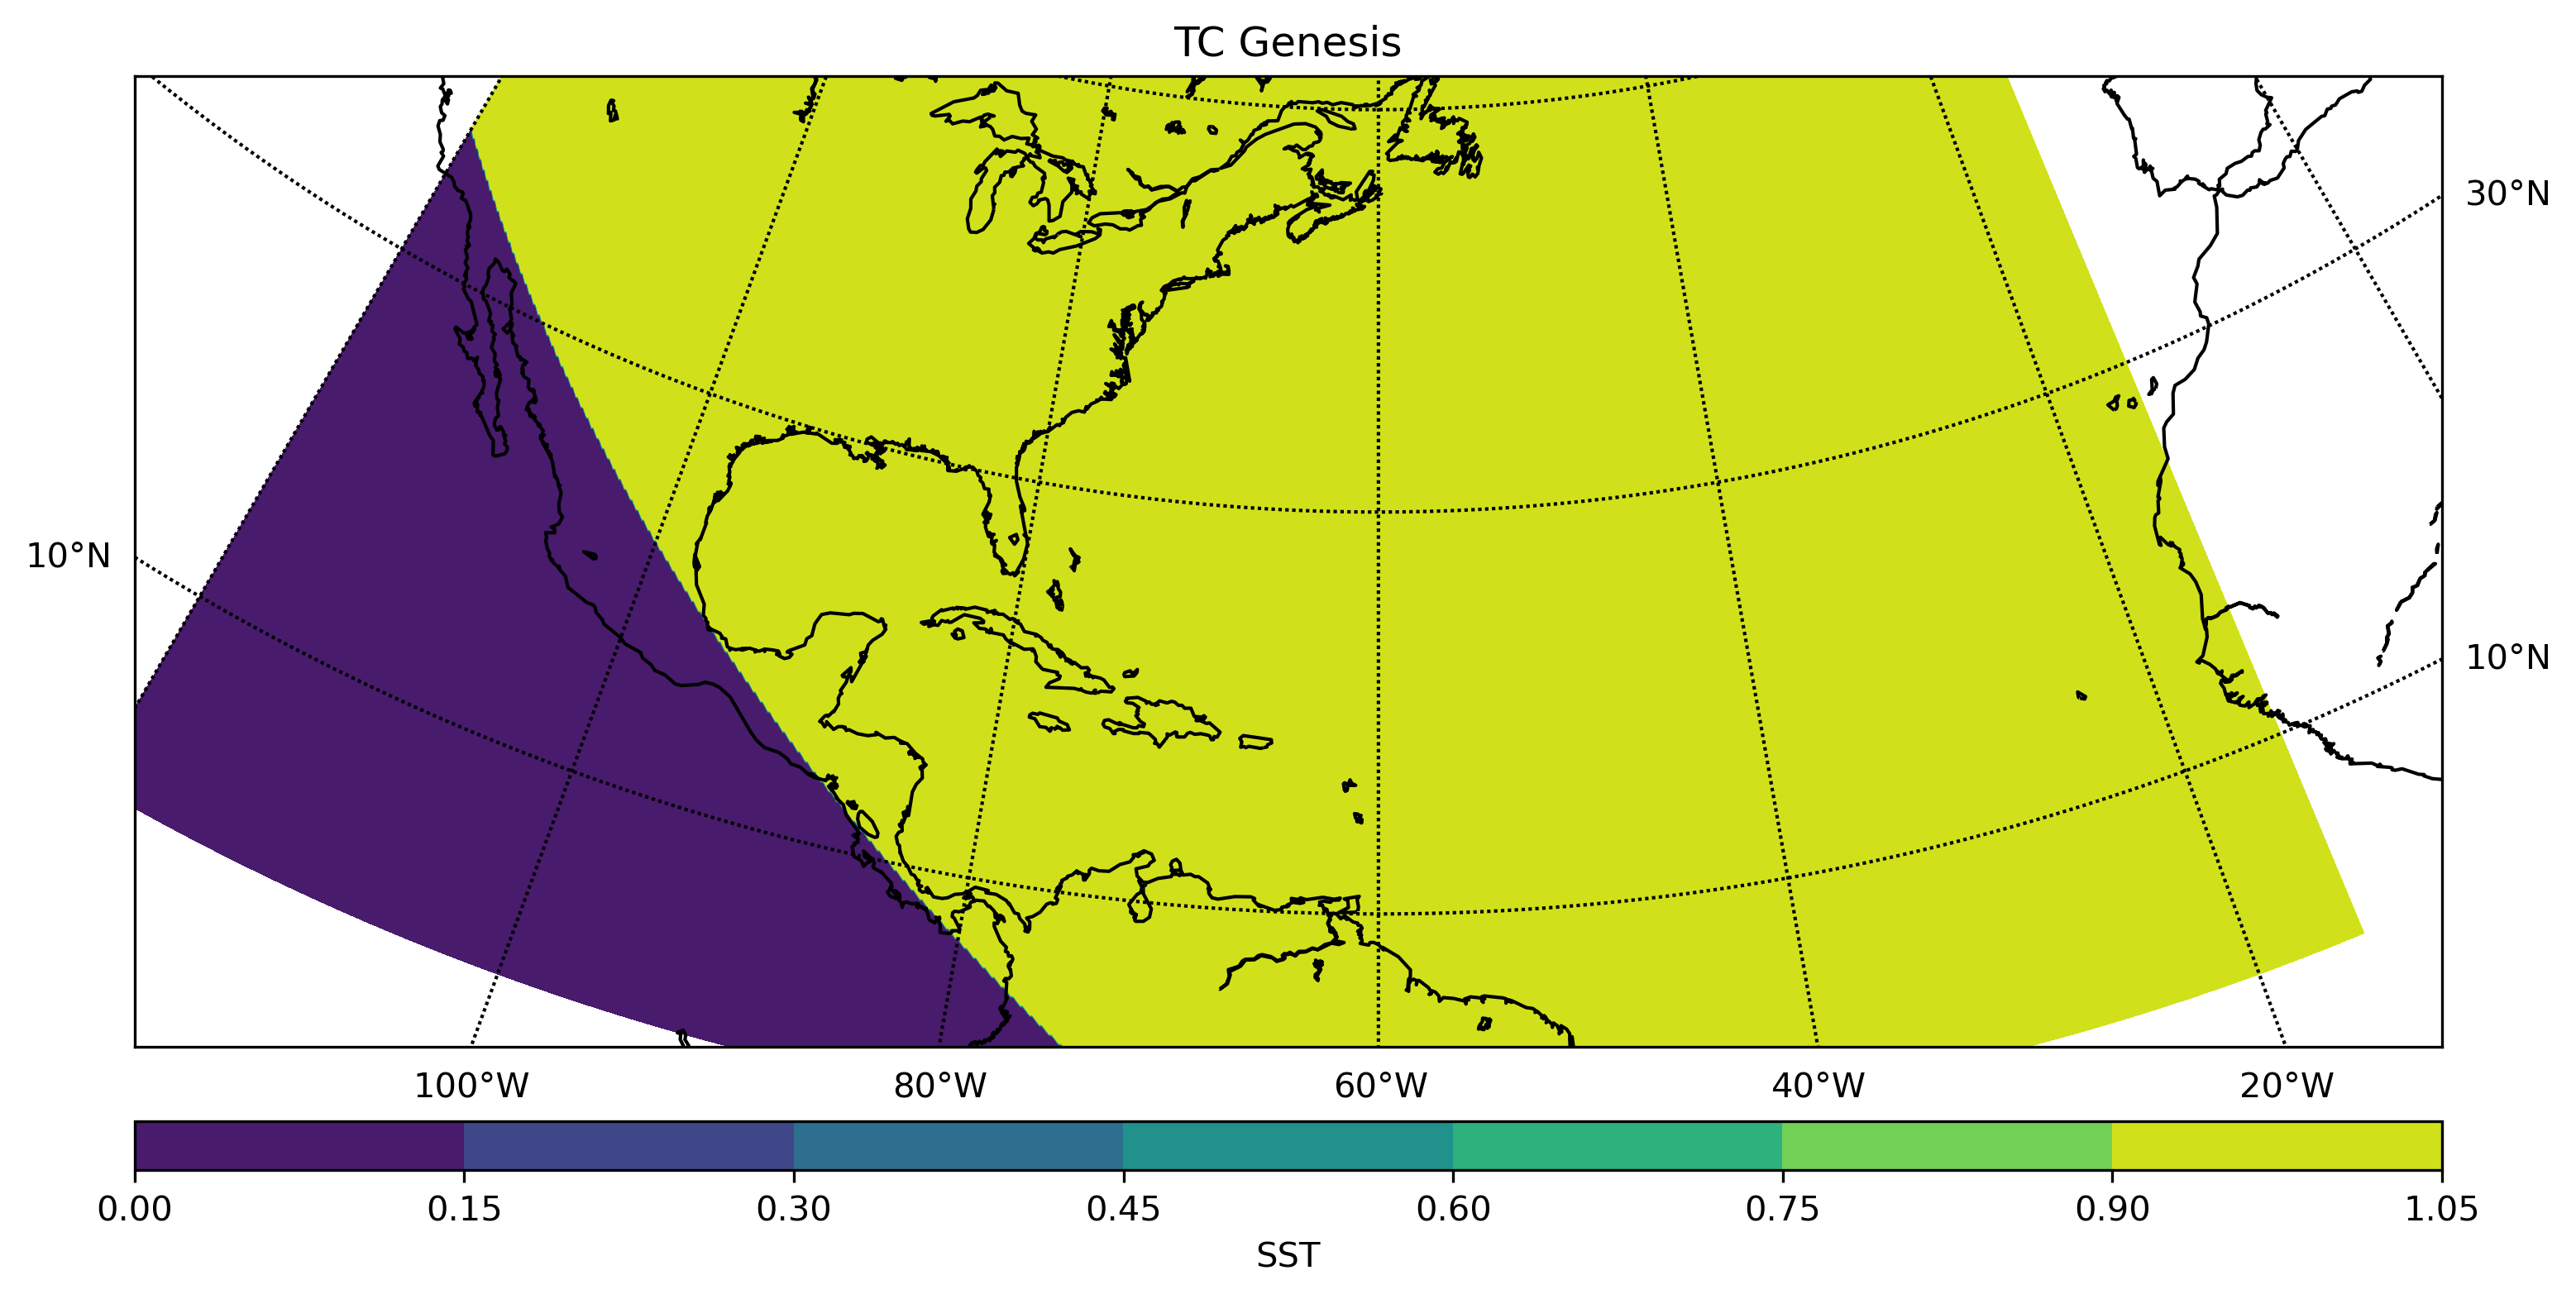

In [87]:
bmap_params = dict(
    llcrnrlon=-113.0,
    llcrnrlat=-9.0,
    urcrnrlon=10.0,
    urcrnrlat=35.0,
    projection="lcc",
    lat_1=20.0,
    lat_2=40.0,
    lon_0=-60.0,
    resolution="l",
    area_thresh=1000.0,
)
fig = plt.figure(figsize=(12, 8), dpi=300)
ax1 = fig.add_subplot(1, 1, 1)
mp = Basemap(
    **bmap_params,
    ax=ax1,
)
xx, yy = mp(lonlon, latlat)
mp.drawcoastlines()
mp.drawparallels(np.arange(10, 70, 20), labels=[1, 1, 0, 0])
mp.drawmeridians(np.arange(-140, 20, 20), labels=[0, 0, 0, 1])

mask = ((-0.75 * lonlon -53) < latlat) 

den = plt.contourf(xx, yy, mask)
mp.colorbar(
    den,
    ax=ax1,
    location="bottom",
    pad=0.3,
    label=f"SST",
)
#mp.scatter(xx[mask], yy[mask])
plt.title("TC Genesis")
plt.show()

In [63]:
plt.imshow(mask)

plt.imshow(Z.filled() > 1000)

In [121]:
rmask = np.ma.is

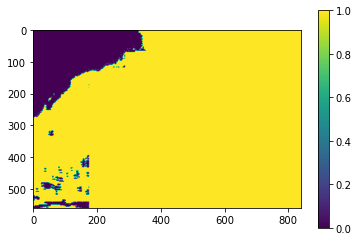

In [128]:
plt.imshow(Z.mask)
plt.colorbar()

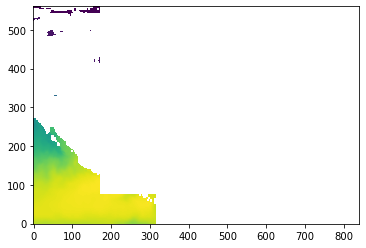

In [101]:
plt.imshow(Z, origin="lower")

In [69]:
def remove_pacific(group):
    tmp_group = group.sort_values("date", ascending=True)

    print(tmp_group.date.is_monotonic)
    return True

In [ ]:
ordf.groupby("tc_id").filter(remove_pacific)

In [62]:
tc_ids_index = ordf.sort_values("lifetime")
tc_ids_index = tc_ids_index.drop_duplicates(subset=["tc_id"], keep="first")
tc_ids_index = tc_ids_index.groupby("cat")["lifetime"].nlargest(8)

In [63]:
tc_ids_index

cat  idx    
-1   3695960    13
     3696846    13
     2999373    13
     3000565    13
     3760481    13
     3761020    13
     3428709    13
     3427968    13
 0   3252624    25
     3718009    25
     3252599    25
     4273807    25
     2874653    25
     4213125    25
     3341787    25
     3341792    25
 1   2324867    43
     927690     43
     2326674    43
     922530     43
     2427902    43
     1098785    43
     1857803    43
     1855335    43
 2   4264927    22
     4264627    22
     3695098    22
     2914340    22
     3365742    22
     3364505    22
     4033828    22
     4324522    22
 3   1141498    44
     607422     44
     1142910    44
     1143804    44
     1142123    44
     608503     44
     1144711    44
     1186137    44
 4   4299723    29
     4300032    29
     3599625    29
     4235316    29
     3598899    29
     2864902    29
     3659706    29
     2863416    29
Name: lifetime, dtype: int64

In [64]:
tc_ids = [ordf.loc[tid].tc_id for cat, tid in tc_ids_index.index]
tc_cats = [cat for cat, tid in tc_ids_index.index]

In [11]:
tcdf = ordf[ordf.tc_id == tc_id]
tcmaxid = tcdf["maxwind"].idxmax()
tcmax = tcdf.loc[tcmaxid]
filtered = ordf.groupby("tc_id").filter(lambda x: close_tracks(x, tcmax))

In [ ]:
jan_id = 0
for tc_id, cat in zip(tc_ids, tc_cats):
    tcdf = ordf[ordf.tc_id == tc_id]
    tcmaxid = tcdf["maxwind"].idxmax()
    tcmax = tcdf.loc[tcmaxid]
    filtered = ordf.groupby("tc_id").filter(lambda x: close_tracks(x, tcmax))
    bmap_params = dict(
        llcrnrlon=-113.0,
        llcrnrlat=-20.0,
        urcrnrlon=40.0,
        urcrnrlat=60.0,
        projection="lcc",
        lat_1=20.0,
        lat_2=40.0,
        lon_0=-60.0,
        resolution="l",
        area_thresh=1000.0,
    )
    fname = f"overlying_tracks_tc_id_{tc_id}_cat_{cat}_jid{jan_id}.jpg"
    res = plot_occurrence(
        filtered, tcmax.tc_id, bmap_params=bmap_params, filename=fname
    )
    jan_id += 1

 44%|████▍     | 28/63 [00:00<00:00, 274.44it/s]

63


 44%|████▍     | 28/63 [00:00<00:00, 277.32it/s]

63


 41%|████▏     | 26/63 [00:00<00:00, 253.50it/s]

63


 43%|████▎     | 27/63 [00:00<00:00, 268.76it/s]

63


 44%|████▍     | 28/63 [00:00<00:00, 276.49it/s]

63


  0%|          | 0/63 [00:00<?, ?it/s]

63


 43%|████▎     | 27/63 [00:00<00:00, 268.10it/s]

63


 44%|████▍     | 28/63 [00:00<00:00, 272.48it/s]

63


100%|██████████| 48/48 [00:00<00:00, 263.17it/s]

48



100%|██████████| 48/48 [00:00<00:00, 271.29it/s]

48



100%|██████████| 12/12 [00:00<00:00, 262.19it/s]

12



100%|██████████| 48/48 [00:00<00:00, 276.17it/s]

48



100%|██████████| 48/48 [00:00<00:00, 257.77it/s]

48



100%|██████████| 48/48 [00:00<00:00, 266.20it/s]

48



100%|██████████| 48/48 [00:00<00:00, 270.12it/s]

48



100%|██████████| 48/48 [00:00<00:00, 261.33it/s]

48



  4%|▍         | 28/744 [00:00<00:02, 270.65it/s]

744


  4%|▎         | 27/744 [00:00<00:02, 265.05it/s]

744


  4%|▍         | 28/744 [00:00<00:02, 275.96it/s]

744


  4%|▍         | 29/744 [00:00<00:02, 282.19it/s]

744


100%|██████████| 744/744 [00:02<00:00, 280.47it/s]
<ipython-input-56-0bbea06d3583>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8), dpi=300)
  4%|▍         | 28/744 [00:00<00:02, 270.84it/s]

744


  4%|▎         | 27/744 [00:00<00:02, 264.93it/s]

744


  4%|▍         | 28/744 [00:00<00:02, 274.02it/s]

744


  4%|▍         | 29/744 [00:00<00:02, 283.19it/s]

744


  3%|▎         | 28/1026 [00:00<00:03, 276.60it/s]

1026


  3%|▎         | 27/1026 [00:00<00:03, 264.73it/s]

1026


  3%|▎         | 28/1026 [00:00<00:03, 275.23it/s]

1026


  3%|▎         | 28/1026 [00:00<00:03, 271.68it/s]

1026


  3%|▎         | 28/1026 [00:00<00:03, 279.99it/s]

1026


  3%|▎         | 26/1026 [00:00<00:03, 254.83it/s]

1026


  3%|▎         | 27/1026 [00:00<00:03, 264.82it/s]

1026


  3%|▎         | 27/1026 [00:00<00:03, 266.49it/s]

1026


  3%|▎         | 26/948 [00:00<00:03, 257.15it/s]

948


  3%|▎         | 26/948 [00:00<00:03, 258.92it/s]

948


  3%|▎         | 26/948 [00:00<00:03, 251.79it/s]

948


  3%|▎         | 27/948 [00:00<00:03, 269.27it/s]

948


  3%|▎         | 27/948 [00:00<00:03, 263.53it/s]

948


  3%|▎         | 27/948 [00:00<00:03, 266.67it/s]

948


  3%|▎         | 26/948 [00:00<00:03, 251.35it/s]

948


  3%|▎         | 26/948 [00:00<00:03, 258.46it/s]

948


100%|██████████| 1026/1026 [00:07<00:00, 134.73it/s]


  1%|          | 12/1026 [00:00<00:08, 117.50it/s]

1026


100%|██████████| 1026/1026 [00:04<00:00, 246.26it/s]


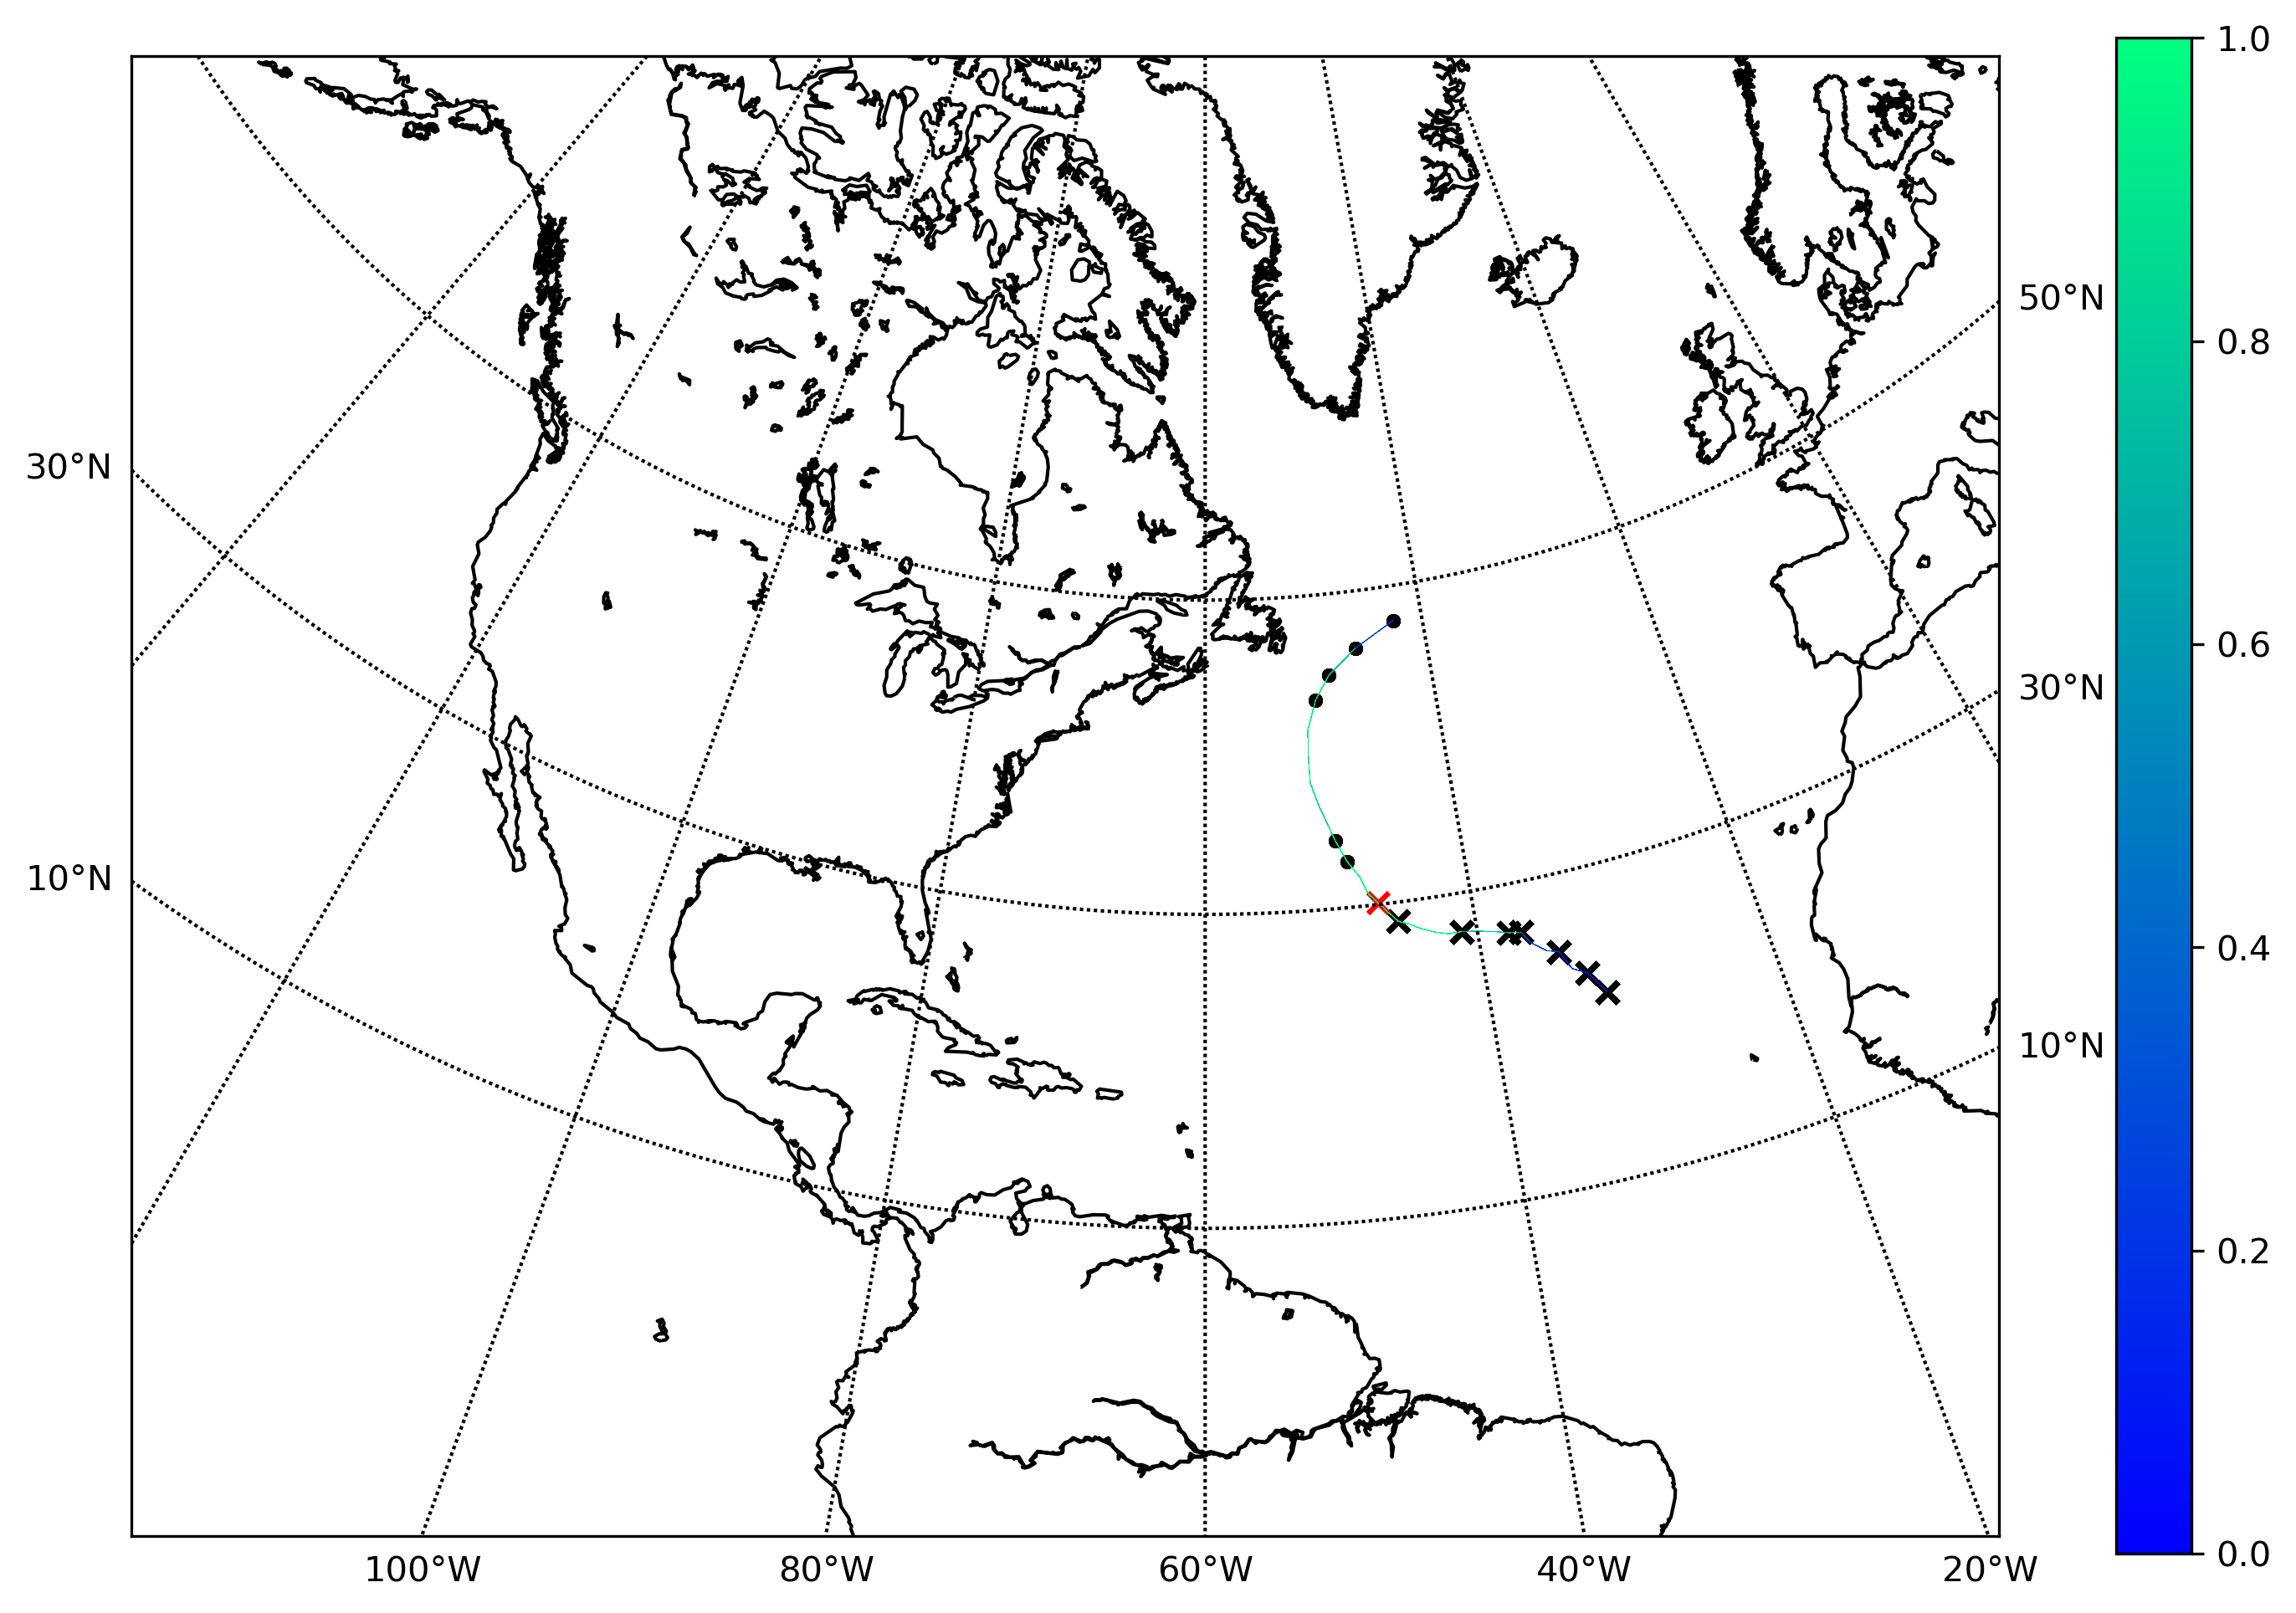

In [39]:
bmap_params = dict(
    llcrnrlon=-113.0,
    llcrnrlat=-20.0,
    urcrnrlon=40.0,
    urcrnrlat=60.0,
    projection="lcc",
    lat_1=20.0,
    lat_2=40.0,
    lon_0=-60.0,
    resolution="l",
    area_thresh=1000.0,
)
fig = plot_occurrence(filtered, tcmax.tc_id, bmap_params=bmap_params)

In [78]:
fig[1]["maxwind"].idxmax()

1500367